In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import NotFittedError

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [1]:

# -----------------------------
# 1. Load Datasets
# -----------------------------

# Replace 'merged_features_drop_cleaned_train_data.csv' and 'merged_features_drop_cleaned_test_data.csv'
# with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# -----------------------------
# 2. Handle Missing 'departure.actualTime' in Test Dataset
# -----------------------------

# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# -----------------------------
# 3. Datetime Conversion
# -----------------------------

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# -----------------------------
# 4. Feature Engineering: Extract Datetime Features
# -----------------------------

# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday
    
    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday
    
    # Calculate delay in minutes
    df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# -----------------------------
# 5. Define Feature Lists
# -----------------------------

# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday',
    'calculated_departure_delay'  # Newly created feature
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]

# -----------------------------
# 6. Handle Missing Values and Define Preprocessing Pipelines
# -----------------------------

# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Polynomial Features
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# -----------------------------
# 7. Prepare Feature Matrices and Target Variable
# -----------------------------

# Define feature matrix X and target vector y for training
# Use 'departure.delay_minutes' as the target variable (numerical and no missing values)
X_reg = train_df[numeric_features + categorical_features]
y_reg = train_df['departure.delay_minutes']  # Corrected target variable

# Check for missing values in the target variable
missing_targets = y_reg.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y_reg.dropna().index
    X_reg = X_reg.loc[non_null_indices]
    y_reg = y_reg.loc[non_null_indices]
else:
    print("\nNo missing values found in the target variable.")

# Define feature matrix for test data
X_test_reg = test_df[numeric_features + categorical_features]

# -----------------------------
# 8. Split Data into Training and Validation Sets
# -----------------------------

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("\nTraining Set Size:", X_train_reg.shape)
print("Validation Set Size:", X_val_reg.shape)
print("Test Set Size:", X_test_reg.shape)

# -----------------------------
# 9. Create and Train the Pipeline with RandomForestRegressor
# -----------------------------

# Initialize the Pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the Pipeline on the Training Data
reg_pipeline.fit(X_train_reg, y_train_reg)

# Make Predictions on the Validation Set
y_pred_reg = reg_pipeline.predict(X_val_reg)

# Evaluate the Model
mae = mean_absolute_error(y_val_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_reg))

print("\nRegression Metrics on Validation Set:")
print("MAE:", mae)
print("RMSE:", rmse)

# -----------------------------
# 10. Hyperparameter Tuning Using GridSearchCV
# -----------------------------

# Define the Hyperparameter Grid for RandomForestRegressor
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__bootstrap': [True, False]
}

# To manage memory, simplify the hyperparameter grid
# For example, reduce the number of values per parameter
param_grid_rf_simplified = {
    'regressor__n_estimators': [100],  # Start with 100 to reduce computational load
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__bootstrap': [True]
}

# Initialize GridSearchCV with reduced hyperparameter grid and limited parallel jobs
grid_search_rf = GridSearchCV(
    reg_pipeline, 
    param_grid_rf_simplified, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=1,  # Set to 1 to reduce memory usage
    verbose=2
)

# Fit GridSearchCV on the Training Data
try:
    grid_search_rf.fit(X_train_reg, y_train_reg)
except ValueError as ve:
    print("\nValueError during GridSearchCV fitting:", ve)
except MemoryError as me:
    print("\nMemoryError during GridSearchCV fitting:", me)
except Exception as e:
    print("\nAn unexpected error occurred during GridSearchCV fitting:", e)

# Check if GridSearchCV was successful
if hasattr(grid_search_rf, 'best_params_'):
    # Output the Best Parameters
    print("\nBest Parameters for RandomForestRegressor:")
    print(grid_search_rf.best_params_)
    
    # Best Model from GridSearchCV
    best_rf_model_reg = grid_search_rf.best_estimator_
    
    # Cross-Validation RMSE for the Best Model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_rf = cross_val_score(
        best_rf_model_reg, 
        X_reg, 
        y_reg, 
        cv=kf, 
        scoring='neg_mean_squared_error',
        n_jobs=1  # Ensure single job to prevent memory issues
    )
    cv_rmse_rf = np.sqrt(-cv_scores_rf)
    print("\nRandom Forest Regression Cross-Validation RMSE:", cv_rmse_rf.mean())
else:
    print("\nGridSearchCV did not complete successfully. Please check the errors above.")

# -----------------------------
# 11. Making Predictions on the Test Dataset
# -----------------------------

if hasattr(grid_search_rf, 'best_estimator_'):
    # IMPORTANT:
    # Use the pipeline's predict method directly on the raw test data
    y_pred_test = best_rf_model_reg.predict(X_test_reg)
    
    # Prepare the Submission DataFrame
    submission_df = pd.DataFrame({
        'ID': range(1, len(test_df) + 1),  # Assuming IDs start from 1
        'Delay': y_pred_test  # Predicted delay durations in minutes
    })
    
    # Ensure the Number of Entries is Exactly 12914 (for Kaggle Submission)
    expected_entries = 12914
    actual_entries = len(submission_df)
    
    if actual_entries > expected_entries:
        print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
        submission_df = submission_df.head(expected_entries)
    elif actual_entries < expected_entries:
        print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
    else:
        print("\nSubmission has the expected 12914 entries.")
    
    # Save the Submission File in the Required Format
    submission_df.to_csv('kaggle_submission_regression.csv', index=False)
    print("Submission file 'kaggle_submission_regression.csv' saved.")
    
    # -----------------------------
    # 12. Optional: Save the Best Model for Future Use
    # -----------------------------
    
    # Save the trained model using joblib
    joblib.dump(best_rf_model_reg, 'best_random_forest_regressor.pkl')
    print("Trained Random Forest model saved as 'best_random_forest_regressor.pkl'.")
else:
    print("\nSkipping test predictions and submission due to GridSearchCV failure.")


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

count    51871.000000
mean        19.425671
std         67.203683
min      -1277.000000
25%          0.000000
50%          8.000000
75%         20.000000
max       1440.000000
Name: departure.delay_minutes, dtype: float64


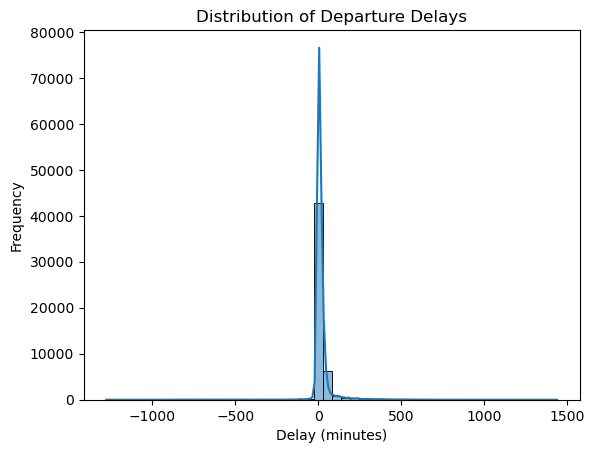

In [15]:
print(train_df['departure.delay_minutes'].describe())
sns.histplot(train_df['departure.delay_minutes'], bins=50, kde=True)
plt.title('Distribution of Departure Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.show()


In [17]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_reg, y_train_reg)
y_dummy_pred = dummy.predict(X_val_reg)
dummy_mae = mean_absolute_error(y_val_reg, y_dummy_pred)
dummy_rmse = np.sqrt(mean_squared_error(y_val_reg, y_dummy_pred))
print(f"Baseline Dummy Regressor MAE: {dummy_mae}")
print(f"Baseline Dummy Regressor RMSE: {dummy_rmse}")


Baseline Dummy Regressor MAE: 24.58409745866055
Baseline Dummy Regressor RMSE: 63.91187955171303


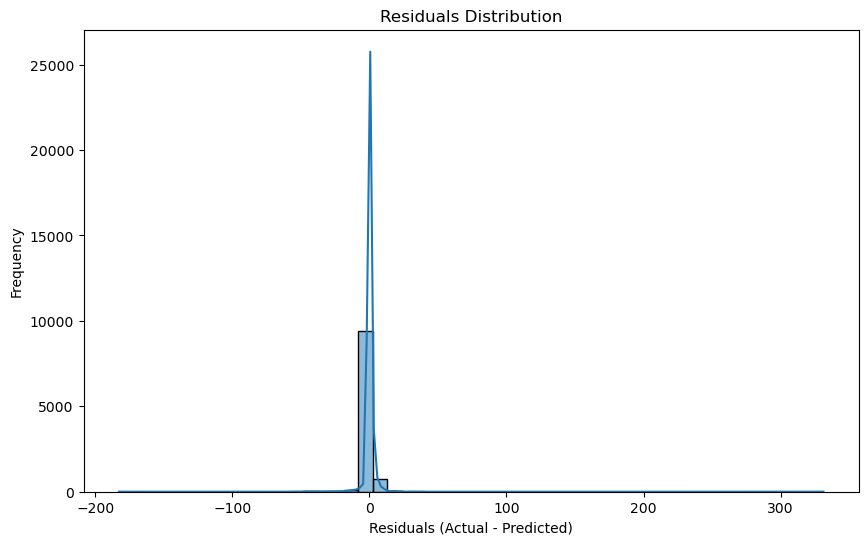

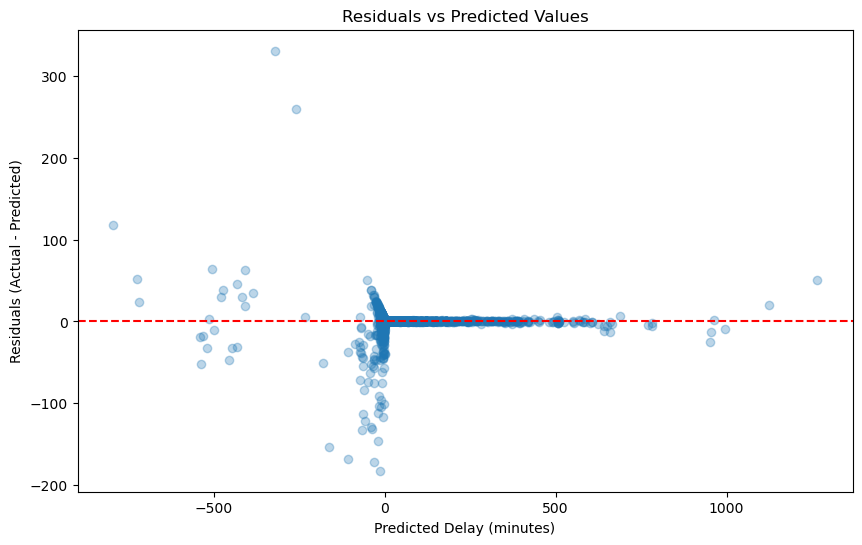

In [19]:
residuals = y_val_reg - y_pred_reg
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(y_pred_reg, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Delay (minutes)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()


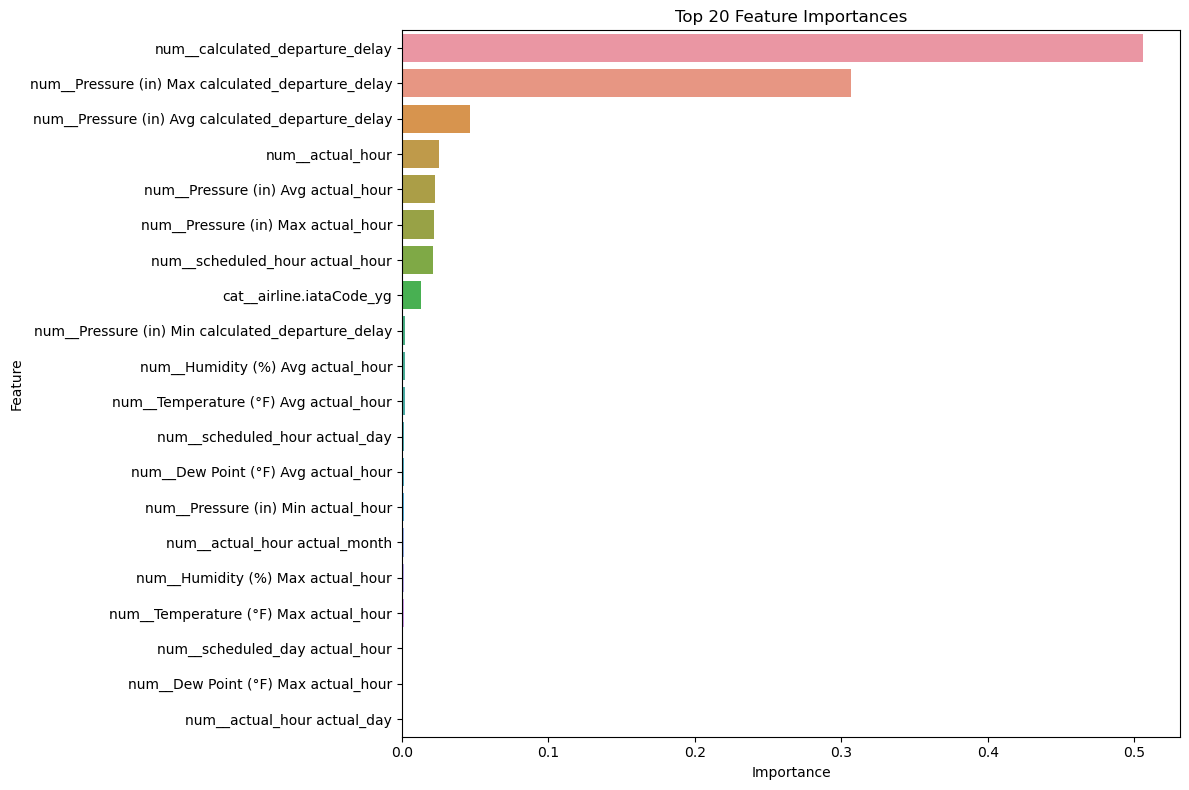

In [21]:
if hasattr(best_rf_model_reg, 'named_steps'):
    importances = best_rf_model_reg.named_steps['regressor'].feature_importances_
    feature_names = best_rf_model_reg.named_steps['preprocessor'].get_feature_names_out()
    
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    # Plot Top 20 Features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [ ]:



# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.exceptions import NotFittedError

# Optional: For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# 1. Load Datasets
# -----------------------------

# Load the datasets
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# -----------------------------
# 2. Handle Missing 'departure.actualTime' in Test Dataset
# -----------------------------

# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# -----------------------------
# 3. Datetime Conversion
# -----------------------------

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')

# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# -----------------------------
# 4. Feature Engineering: Extract Datetime Features
# -----------------------------

# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday
    
    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday
    
    # Calculate delay in minutes
    df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays
    
    # Additional Temporal Features
    df['scheduled_minute'] = df['departure.scheduledTime'].dt.minute
    df['scheduled_second'] = df['departure.scheduledTime'].dt.second
    df['actual_minute'] = df['departure.actualTime'].dt.minute
    df['actual_second'] = df['departure.actualTime'].dt.second

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# -----------------------------
# 5. Define Feature Lists
# -----------------------------

# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday',
    'calculated_departure_delay',
    'scheduled_minute', 'scheduled_second', 'actual_minute', 'actual_second'  # Newly added features
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]

# -----------------------------
# 6. Handle Missing Values and Define Preprocessing Pipelines
# -----------------------------

# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Polynomial Features
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # One-hot encode categorical features as dense
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# -----------------------------
# 7. Prepare Feature Matrices and Target Variable
# -----------------------------

# Define feature matrix X and target vector y for training
# Use 'departure.delay_minutes' as the target variable (numerical and no missing values)
X_reg = train_df[numeric_features + categorical_features]
y_reg = train_df['departure.delay_minutes']  # Corrected target variable

# Check for missing values in the target variable
missing_targets = y_reg.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y_reg.dropna().index
    X_reg = X_reg.loc[non_null_indices]
    y_reg = y_reg.loc[non_null_indices]
else:
    print("\nNo missing values found in the target variable.")

# Define feature matrix for test data
X_test_reg = test_df[numeric_features + categorical_features]

# -----------------------------
# 8. Split Data into Training and Validation Sets
# -----------------------------

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("\nTraining Set Size:", X_train_reg.shape)
print("Validation Set Size:", X_val_reg.shape)
print("Test Set Size:", X_test_reg.shape)

# -----------------------------
# 9. Create and Train the Pipeline with RandomForestRegressor
# -----------------------------

# Initialize the Pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the Pipeline on the Training Data
reg_pipeline.fit(X_train_reg, y_train_reg)

# Make Predictions on the Validation Set
y_pred_reg = reg_pipeline.predict(X_val_reg)

# Evaluate the Model
mae = mean_absolute_error(y_val_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_reg))

print("\nRegression Metrics on Validation Set:")
print("MAE:", mae)
print("RMSE:", rmse)

# -----------------------------
# 10. Advanced Hyperparameter Tuning Using RandomizedSearchCV
# -----------------------------

from scipy.stats import randint, uniform

# Define the Hyperparameter Distribution for RandomForestRegressor
param_dist_rf = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': [None] + list(range(10, 51, 10)),
    'regressor__min_samples_split': randint(2, 11),
    'regressor__min_samples_leaf': randint(1, 5),
    'regressor__bootstrap': [True, False],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=reg_pipeline,
    param_distributions=param_dist_rf,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit RandomizedSearchCV on the Training Data
try:
    random_search_rf.fit(X_train_reg, y_train_reg)
except ValueError as ve:
    print("\nValueError during RandomizedSearchCV fitting:", ve)
except MemoryError as me:
    print("\nMemoryError during RandomizedSearchCV fitting:", me)
except Exception as e:
    print("\nAn unexpected error occurred during RandomizedSearchCV fitting:", e)

# Check if RandomizedSearchCV was successful
if hasattr(random_search_rf, 'best_params_'):
    # Output the Best Parameters
    print("\nBest Parameters from RandomizedSearchCV for RandomForestRegressor:")
    print(random_search_rf.best_params_)
    
    # Best Model from RandomizedSearchCV
    best_rf_model_reg = random_search_rf.best_estimator_
    
    # Make Predictions on the Validation Set
    y_pred_rf_tuned = best_rf_model_reg.predict(X_val_reg)
    
    # Evaluate the Tuned Model
    mae_tuned = mean_absolute_error(y_val_reg, y_pred_rf_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_val_reg, y_pred_rf_tuned))
    
    print("\nTuned Random Forest Regression Metrics on Validation Set:")
    print("MAE:", mae_tuned)
    print("RMSE:", rmse_tuned)
    
    # Cross-Validation RMSE for the Best Model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_rf = cross_val_score(
        best_rf_model_reg, 
        X_reg, 
        y_reg, 
        cv=kf, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    cv_rmse_rf = np.sqrt(-cv_scores_rf)
    print(f"\nRandom Forest Regression Cross-Validation RMSE: {cv_rmse_rf.mean():.4f} ± {cv_rmse_rf.std():.4f}")
    
    # Feature Importance Analysis
    importances = best_rf_model_reg.named_steps['regressor'].feature_importances_
    onehot_features = best_rf_model_reg.named_steps['preprocessor'] \
        .named_transformers_['cat'] \
        .named_steps['onehot'] \
        .get_feature_names_out(categorical_features)
    poly_features = best_rf_model_reg.named_steps['preprocessor'] \
        .named_transformers_['num'] \
        .named_steps['poly'] \
        .get_feature_names_out(numeric_features)
    all_features = list(poly_features) + list(onehot_features)
    
    feature_importances = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nTop 20 Feature Importances:")
    print(feature_importances.head(20))
    
    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances from Tuned Random Forest')
    plt.tight_layout()
    plt.show()
else:
    print("\nRandomizedSearchCV did not complete successfully. Please check the errors above.")

# -----------------------------
# 11. Implement Stacking Regressor (Optional)
# -----------------------------

from sklearn.linear_model import RidgeCV

# Define base models
base_models = [
    ('random_forest', RandomForestRegressor(
        n_estimators=random_search_rf.best_params_['regressor__n_estimators'],
        max_depth=random_search_rf.best_params_['regressor__max_depth'],
        min_samples_split=random_search_rf.best_params_['regressor__min_samples_split'],
        min_samples_leaf=random_search_rf.best_params_['regressor__min_samples_leaf'],
        bootstrap=random_search_rf.best_params_['regressor__bootstrap'],
        max_features=random_search_rf.best_params_['regressor__max_features'],
        random_state=42
    )),
    ('ridge', RidgeCV(alphas=np.logspace(-6, 6, 13)))
]

# Define the meta-model
meta_model = RidgeCV()

# Initialize the Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Create a pipeline with the Stacking Regressor
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking_regressor', stacking_regressor)
])

# Fit the Stacking Regressor pipeline
stacking_pipeline.fit(X_train_reg, y_train_reg)

# Predict on the validation set
y_pred_stack = stacking_pipeline.predict(X_val_reg)

# Evaluate the Stacking Regressor
mae_stack = mean_absolute_error(y_val_reg, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_val_reg, y_pred_stack))

print("\nStacking Regressor Metrics on Validation Set:")
print("MAE:", mae_stack)
print("RMSE:", rmse_stack)

# Cross-Validation RMSE for the Stacking Regressor
cv_scores_stack = cross_val_score(
    stacking_pipeline, 
    X_reg, 
    y_reg, 
    cv=kf, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
cv_rmse_stack = np.sqrt(-cv_scores_stack)
print(f"\nStacking Regressor Cross-Validation RMSE: {cv_rmse_stack.mean():.4f} ± {cv_rmse_stack.std():.4f}")

# -----------------------------
# 12. Making Final Predictions on the Test Dataset
# -----------------------------

# Decide whether to use the tuned Random Forest or the Stacking Regressor
# Assuming Stacking Regressor performed better
final_model = stacking_pipeline  # or best_rf_model_reg

# Fit the final model on the entire training data
final_model.fit(X_reg, y_reg)

# Make predictions on the test dataset
y_pred_test_final = final_model.predict(X_test_reg)

# Ensure no negative predictions
y_pred_test_final = np.clip(y_pred_test_final, a_min=0, a_max=None)

# Prepare the Submission DataFrame
submission_df_final = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),  # Adjust if there's a specific ID column
    'Delay': y_pred_test_final  # Predicted delay durations in minutes
})

# Ensure the Number of Entries is Exactly 12914 (for Kaggle Submission)
expected_entries = 12914
actual_entries = len(submission_df_final)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df_final = submission_df_final.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected 12914 entries.")

# Save the Submission File in the Required Format
submission_filename_final = 'kaggle_submission_regression_final.csv'
submission_df_final.to_csv(submission_filename_final, index=False)
print(f"Submission file '{submission_filename_final}' saved successfully.")

# -----------------------------
# 13. Saving the Final Model
# -----------------------------

# Save the trained model using joblib
joblib.dump(final_model, 'final_regression_model.pkl')
print("Final regression model saved as 'final_regression_model.pkl'.")


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

In [5]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.exceptions import NotFittedError

# For saving the model
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# 1. Load Datasets
# -----------------------------
# Replace 'merged_features_drop_cleaned_train_data.csv' and 'merged_features_drop_cleaned_test_data.csv'
# with your actual file paths if they are located elsewhere
train_df = pd.read_csv('merged_features_drop_cleaned_train_data.csv')
test_df = pd.read_csv('merged_features_drop_cleaned_test_data.csv')

# Display initial information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# -----------------------------
# 2. Handle Missing 'departure.actualTime' in Test Dataset
# -----------------------------
# Check if 'departure.actualTime' exists in test_df
if 'departure.actualTime' not in test_df.columns:
    print("\nColumn 'departure.actualTime' not found in test dataset. Imputing with 'departure.scheduledTime'.")
    # Impute 'departure.actualTime' with 'departure.scheduledTime' assuming no delay
    test_df['departure.actualTime'] = test_df['departure.scheduledTime']
else:
    # Ensure 'departure.actualTime' is in datetime format
    test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
    # Fill missing 'departure.actualTime' with 'departure.scheduledTime'
    test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# -----------------------------
# 3. Datetime Conversion
# -----------------------------
# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Training Data
train_df['departure.scheduledTime'] = pd.to_datetime(train_df['departure.scheduledTime'], errors='coerce')
train_df['departure.actualTime'] = pd.to_datetime(train_df['departure.actualTime'], errors='coerce')
# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Training Data
train_df['departure.actualTime'].fillna(train_df['departure.scheduledTime'], inplace=True)

# Convert 'departure.scheduledTime' and 'departure.actualTime' to datetime in Test Data
test_df['departure.scheduledTime'] = pd.to_datetime(test_df['departure.scheduledTime'], errors='coerce')
test_df['departure.actualTime'] = pd.to_datetime(test_df['departure.actualTime'], errors='coerce')
# Fill any missing 'departure.actualTime' with 'departure.scheduledTime' in Test Data
test_df['departure.actualTime'].fillna(test_df['departure.scheduledTime'], inplace=True)

# Verify the conversion
print("\nAfter Datetime Conversion:")
print("Training Data 'departure.scheduledTime' dtype:", train_df['departure.scheduledTime'].dtype)
print("Training Data 'departure.actualTime' dtype:", train_df['departure.actualTime'].dtype)
print("Test Data 'departure.scheduledTime' dtype:", test_df['departure.scheduledTime'].dtype)
print("Test Data 'departure.actualTime' dtype:", test_df['departure.actualTime'].dtype)

# -----------------------------
# 4. Feature Engineering: Extract Datetime Features
# -----------------------------
# Function to extract datetime features
def extract_datetime_features(df):
    df['scheduled_hour'] = df['departure.scheduledTime'].dt.hour
    df['scheduled_day'] = df['departure.scheduledTime'].dt.day
    df['scheduled_month'] = df['departure.scheduledTime'].dt.month
    df['scheduled_weekday'] = df['departure.scheduledTime'].dt.weekday

    df['actual_hour'] = df['departure.actualTime'].dt.hour
    df['actual_day'] = df['departure.actualTime'].dt.day
    df['actual_month'] = df['departure.actualTime'].dt.month
    df['actual_weekday'] = df['departure.actualTime'].dt.weekday

    # Calculate delay in minutes
    df['calculated_departure_delay'] = (df['departure.actualTime'] - df['departure.scheduledTime']).dt.total_seconds() / 60
    df['calculated_departure_delay'] = df['calculated_departure_delay'].clip(lower=0)  # Ensure no negative delays

# Apply the function to both train and test datasets
extract_datetime_features(train_df)
extract_datetime_features(test_df)

# -----------------------------
# 5. Define Feature Lists
# -----------------------------
# Define numeric features
numeric_features = [
    'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min',
    'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min',
    'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min',
    'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min',
    'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min',
    'Precipitation (in) Total',
    'scheduled_hour', 'scheduled_day', 'scheduled_month', 'scheduled_weekday',
    'actual_hour', 'actual_day', 'actual_month', 'actual_weekday',
    'calculated_departure_delay'  # Newly created feature
]

# Define categorical features
categorical_features = [
    'departure.iataCode', 'departure.icaoCode', 'airline.iataCode'
]

# -----------------------------
# 6. Handle Missing Values and Define Preprocessing Pipelines
# -----------------------------
# Numeric Transformer Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Polynomial Features
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Categorical Transformer Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine Preprocessing for Numeric and Categorical Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# -----------------------------
# 7. Prepare Feature Matrices and Target Variable
# -----------------------------
# Define feature matrix X and target vector y for training
# Use 'departure.delay_minutes' as the target variable (numerical and no missing values)
X_reg = train_df[numeric_features + categorical_features]
y_reg = train_df['departure.delay_minutes']  # Corrected target variable

# Check for missing values in the target variable
missing_targets = y_reg.isnull().sum()
if missing_targets > 0:
    print(f"\nWarning: There are {missing_targets} missing values in the target variable. Dropping these rows.")
    # Drop rows with missing target variable
    non_null_indices = y_reg.dropna().index
    X_reg = X_reg.loc[non_null_indices]
    y_reg = y_reg.loc[non_null_indices]
else:
    print("\nNo missing values found in the target variable.")

# Define feature matrix for test data
X_test_reg = test_df[numeric_features + categorical_features]


# ... (Previous code remains the same)

# -----------------------------
# 8. Split Data into Training and Validation Sets
# -----------------------------
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)
print("\nTraining Set Size:", X_train_reg.shape)
print("Validation Set Size:", X_val_reg.shape)
print("Test Set Size:", X_test_reg.shape)

# -----------------------------
# 9. Create and Train and Evaluate All Models
# -----------------------------

from sklearn.linear_model import RidgeCV  # Import RidgeCV

models_reg = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': RidgeCV(alphas=np.logspace(-3, 3, 10)), 
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1), #n_jobs=-1 to use all processors
    'SVR': SVR(kernel='rbf', cache_size=2000), # Added cache_size for large datasets
}

performance_reg = {}
for model_name, model in models_reg.items():
    print(f"\nTraining and Evaluating {model_name}...")
    reg_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    try:
      reg_pipeline.fit(X_train_reg, y_train_reg)
      y_pred_reg = reg_pipeline.predict(X_val_reg)
      mae = mean_absolute_error(y_val_reg, y_pred_reg)
      rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_reg))
      performance_reg[model_name] = {'MAE': mae, 'RMSE': rmse}
      print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

      #Cross-validation
      kf = KFold(n_splits=5, shuffle=True, random_state=42)
      cv_scores = cross_val_score(reg_pipeline, X_reg, y_reg, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
      cv_rmse = np.sqrt(-cv_scores)
      print(f"{model_name} - Cross-Validation RMSE: {cv_rmse.mean():.2f}")

    except (ValueError, MemoryError) as e:
      print(f"Error training {model_name}: {e}")
      continue

# -----------------------------
# 10. Stacking Regressor
# -----------------------------
print("\nTraining and Evaluating Stacking Regressor...")
try:
    estimators = [
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1)),
        ('ridge', RidgeCV(alphas=np.logspace(-3, 3, 10))), 
        ('dt', DecisionTreeRegressor(random_state=42))
    ]
    stacking_reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)
    stacking_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', stacking_reg)
    ])
    stacking_pipeline.fit(X_train_reg, y_train_reg)
    y_pred_stacking = stacking_pipeline.predict(X_val_reg)
    mae_stacking = mean_absolute_error(y_val_reg, y_pred_stacking)
    rmse_stacking = np.sqrt(mean_squared_error(y_val_reg, y_pred_stacking))
    print(f"Stacking Regressor - MAE: {mae_stacking:.2f}, RMSE: {rmse_stacking:.2f}")

    # Cross-validation for Stacking Regressor
    cv_scores_stacking = cross_val_score(stacking_pipeline, X_reg, y_reg, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse_stacking = np.sqrt(-cv_scores_stacking)
    print(f"Stacking Regressor - Cross-Validation RMSE: {cv_rmse_stacking.mean():.2f}")

except (ValueError, MemoryError) as e:
    print(f"Error training Stacking Regressor: {e}")

# -----------------------------
# 11. Making Predictions on the Test Dataset (using best model)
# -----------------------------
best_model_name = min(performance_reg, key=lambda k: performance_reg[k]['RMSE'])
best_model = models_reg[best_model_name]
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', best_model)])

if 'stacking_pipeline' in locals():
    if rmse_stacking < performance_reg[best_model_name]['RMSE']:
        best_pipeline = stacking_pipeline
        print("\nStacking Regressor is the best model.")
    else:
        print(f"\n{best_model_name} is the best model.")

best_pipeline.fit(X_train_reg, y_train_reg)
y_pred_test = best_pipeline.predict(X_test_reg)

submission_df = pd.DataFrame({
    'ID': range(1, len(test_df) + 1),
    'Delay': y_pred_test
})

# Ensure the Number of Entries is Exactly 12914 (for Kaggle Submission)
expected_entries = 12914
actual_entries = len(submission_df)

if actual_entries > expected_entries:
    print(f"\nTrimming submission from {actual_entries} to {expected_entries} entries.")
    submission_df = submission_df.head(expected_entries)
elif actual_entries < expected_entries:
    print(f"\nWarning: Submission has only {actual_entries} entries. Check the test data.")
else:
    print("\nSubmission has the expected 12914 entries.")

submission_df.to_csv('kaggle_submission_regression.csv', index=False)
print("Submission file 'kaggle_submission_regression.csv' saved.")

# Save the Best Model
joblib.dump(best_pipeline, 'final_regression_model.pkl')
print("Trained model saved as 'final_regression_model.pkl'.")

# -----------------------------
# 12. Plotting Residuals (for best model)
# -----------------------------
residuals = y_val_reg - best_pipeline.predict(X_val_reg)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residual Histogram')
plt.subplot(1, 2, 2)
plt.scatter(best_pipeline.predict(X_val_reg), residuals)
plt.title('Residual Scatter Plot')
plt.tight_layout()
plt.show()

# -----------------------------
# 13. Plotting Feature Importances (for Random Forest if it's the best model)
# -----------------------------
if best_model_name == 'Random Forest Regressor':
    try:
        # Get feature importances after preprocessing
        feature_importances = best_pipeline.named_steps['regressor'].feature_importances_

        # Get feature names after preprocessing (handling one-hot encoding)
        ohe_feature_names = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
        all_feature_names = numeric_features + list(ohe_feature_names)

        # Create a DataFrame for feature importances
        importances_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
        importances_df = importances_df.sort_values(by='Importance', ascending=False)

        # Plot feature importances
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=importances_df.head(10))  # Show top 10
        plt.title('Top 10 Feature Importances (Random Forest)')
        plt.show()
    except AttributeError:
        print("Feature importances are not available for this model.")

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51871 entries, 0 to 51870
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status                     51871 non-null  int64  
 1   departure.iataCode         51871 non-null  object 
 2   departure.icaoCode         51871 non-null  object 
 3   departure.terminal         51871 non-null  object 
 4   departure.scheduledTime    51871 non-null  object 
 5   departure.estimatedTime    51871 non-null  object 
 6   departure.actualTime       51871 non-null  object 
 7   departure.estimatedRunway  51871 non-null  object 
 8   departure.actualRunway     51871 non-null  object 
 9   arrival.scheduledTime      51871 non-null  object 
 10  arrival.estimatedTime      51871 non-null  object 
 11  airline.iataCode           51871 non-null  object 
 12  airline.icaoCode           51871 non-null  object 
 13  flight.number             

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.
